In [1]:
import numpy as np
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. **Modeling wine preferences by data mining from physicochemical properties.** *Decision Support Systems*, 47(4):547-553, 2009: имеются оценки качества 6497 португальских вин Vinho Verde, выставленные дегустаторами при слепом тестировании в баллах по шкале от 0 до 10. 

Прочитаем данные:

In [3]:
wine = pd.read_csv('wine_data.csv', sep='\t', header=0)
wine = wine.sample(frac=1)

Вот так выглядит распределение экспертных оценок вин в выборке:

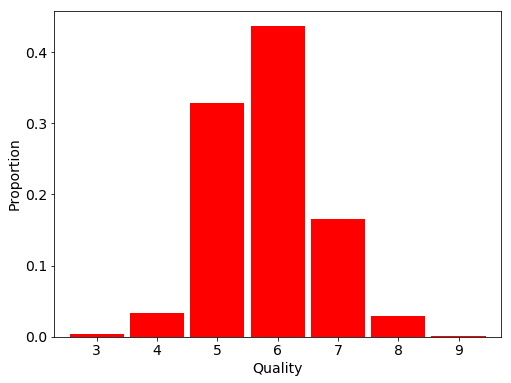

In [4]:
plt.figure(figsize(8,6))
stat = wine.groupby('quality')['quality'].agg(lambda x : float(len(x))/wine.shape[0])
stat.plot(kind='bar', fontsize=14, width=0.9, color="red")
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

Попробуем построить модель, по параметрам вина, предсказывающую его оценку.  
Отделим 25% выборки для контроля качества предсказания:

In [5]:
wine

,Type,Fixed acidity (g/l),Volatile acidity (g/l),Citric acid (g/l),Residual sugar (g/l),Chlorides (g/l),Free sulfur dioxide (mg/l),Total sulfur dioxide (mg/l),Density (g/cm3),pH,Sulphates (g/l),Alcohol (%),quality
2915,white,7.9,0.255,0.26,2.00,0.026,40.0,190.0,0.99320,3.04,0.39,11.2,6
2801,white,6.4,0.300,0.38,7.80,0.046,35.0,192.0,0.99550,3.10,0.37,9.0,5
5346,white,6.8,0.220,0.30,10.60,0.070,67.0,194.0,0.99654,2.89,0.42,9.0,6
3609,white,7.0,0.250,0.56,2.00,0.035,20.0,95.0,0.99180,3.23,0.53,11.0,6
5196,white,6.6,0.190,0.28,11.80,0.042,54.0,137.0,0.99492,3.18,0.37,10.8,6
4051,white,7.3,0.190,0.27,1.60,0.027,35.0,136.0,0.99248,3.38,0.54,11.0,7
3391,white,7.8,0.220,0.36,1.40,0.056,21.0,153.0,0.99300,3.20,0.53,10.4,6
573,red,10.5,0.590,0.49,2.10,0.070,14.0,47.0,0.99910,3.30,0.56,9.6,4
3975,white,7.2,0.200,0.30,2.00,0.039,43.0,188.0,0.99110,3.30,0.41,12.0,6
171,red,8.0,0.420,0.17,2.00,0.073,6.0,18.0,0.99720,3.29,0.61,9.2,6


In [6]:
X_train, X_test, y_train, y_test = train_test_split(wine.loc[:, wine.columns != 'quality'],
                                                    wine['quality'], test_size=0.25,  stratify=wine['quality'])

Сделаем метки:

In [7]:
X_train['Type'] = X_train['Type'].apply(lambda x : -1 if x == 'red' else 1)
X_test['Type'] = X_test['Type'].apply(lambda x : -1 if x == 'red' else 1)

In [8]:
np.mean(y_train)

5.818965517241379

## Тип вина

У нас есть информация о типе вина. Видно, что выборка неравномерная:

In [9]:
wine.groupby('Type')['Type'].count()

Type
red      1599
white    4898
Name: Type, dtype: int64

Распределения оценок по типам довольно сильно отличаются:

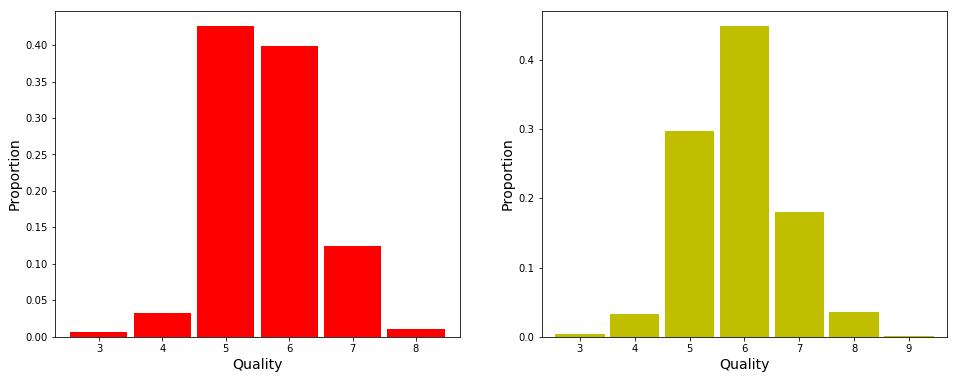

In [10]:
plt.figure(figsize(16,6))
plt.subplot(121)
stat_red = wine[wine['Type'] == 'red'].groupby('quality')['quality'].agg(lambda x: float(len(x))/wine[wine['Type'] == 'red'].shape[0])
stat_red.plot(kind='bar', color='r', width=0.9)
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

plt.subplot(122)
stat_white = wine[wine['Type'] == 'white'].groupby('quality')['quality'].agg(lambda x: float(len(x))/wine[wine['Type'] == 'white'].shape[0])
stat_white.plot(color='y', kind='bar', width=0.9)
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

Мы видим, что экспертные оценки отдельно по этим категориям существенно отличаются. Так, большая часть белых вин получает оценку в 6 баллов, а большая часть красных — в 5.Нет ни одного красного вина, которое получает оценку 9 баллов.

## Предсказание по всем признакам

Кроме типа, датасет содержит 11 признаков, описывающих химический состав вина:

In [11]:
wine.head()

,Type,Fixed acidity (g/l),Volatile acidity (g/l),Citric acid (g/l),Residual sugar (g/l),Chlorides (g/l),Free sulfur dioxide (mg/l),Total sulfur dioxide (mg/l),Density (g/cm3),pH,Sulphates (g/l),Alcohol (%),quality
2915,white,7.9,0.255,0.26,2.0,0.026,40.0,190.0,0.99320,3.04,0.39,11.2,6
2801,white,6.4,0.300,0.38,7.8,0.046,35.0,192.0,0.99550,3.10,0.37,9.0,5
5346,white,6.8,0.220,0.30,10.6,0.070,67.0,194.0,0.99654,2.89,0.42,9.0,6
3609,white,7.0,0.250,0.56,2.0,0.035,20.0,95.0,0.99180,3.23,0.53,11.0,6
5196,white,6.6,0.190,0.28,11.8,0.042,54.0,137.0,0.99492,3.18,0.37,10.8,6


Построим графики, где по горизонтальной оси отложена оценка вина, а по вертикальной - один из признаков. Белые точки - белые вина. красные - красные. Каждая точка соответствует одному образцу.

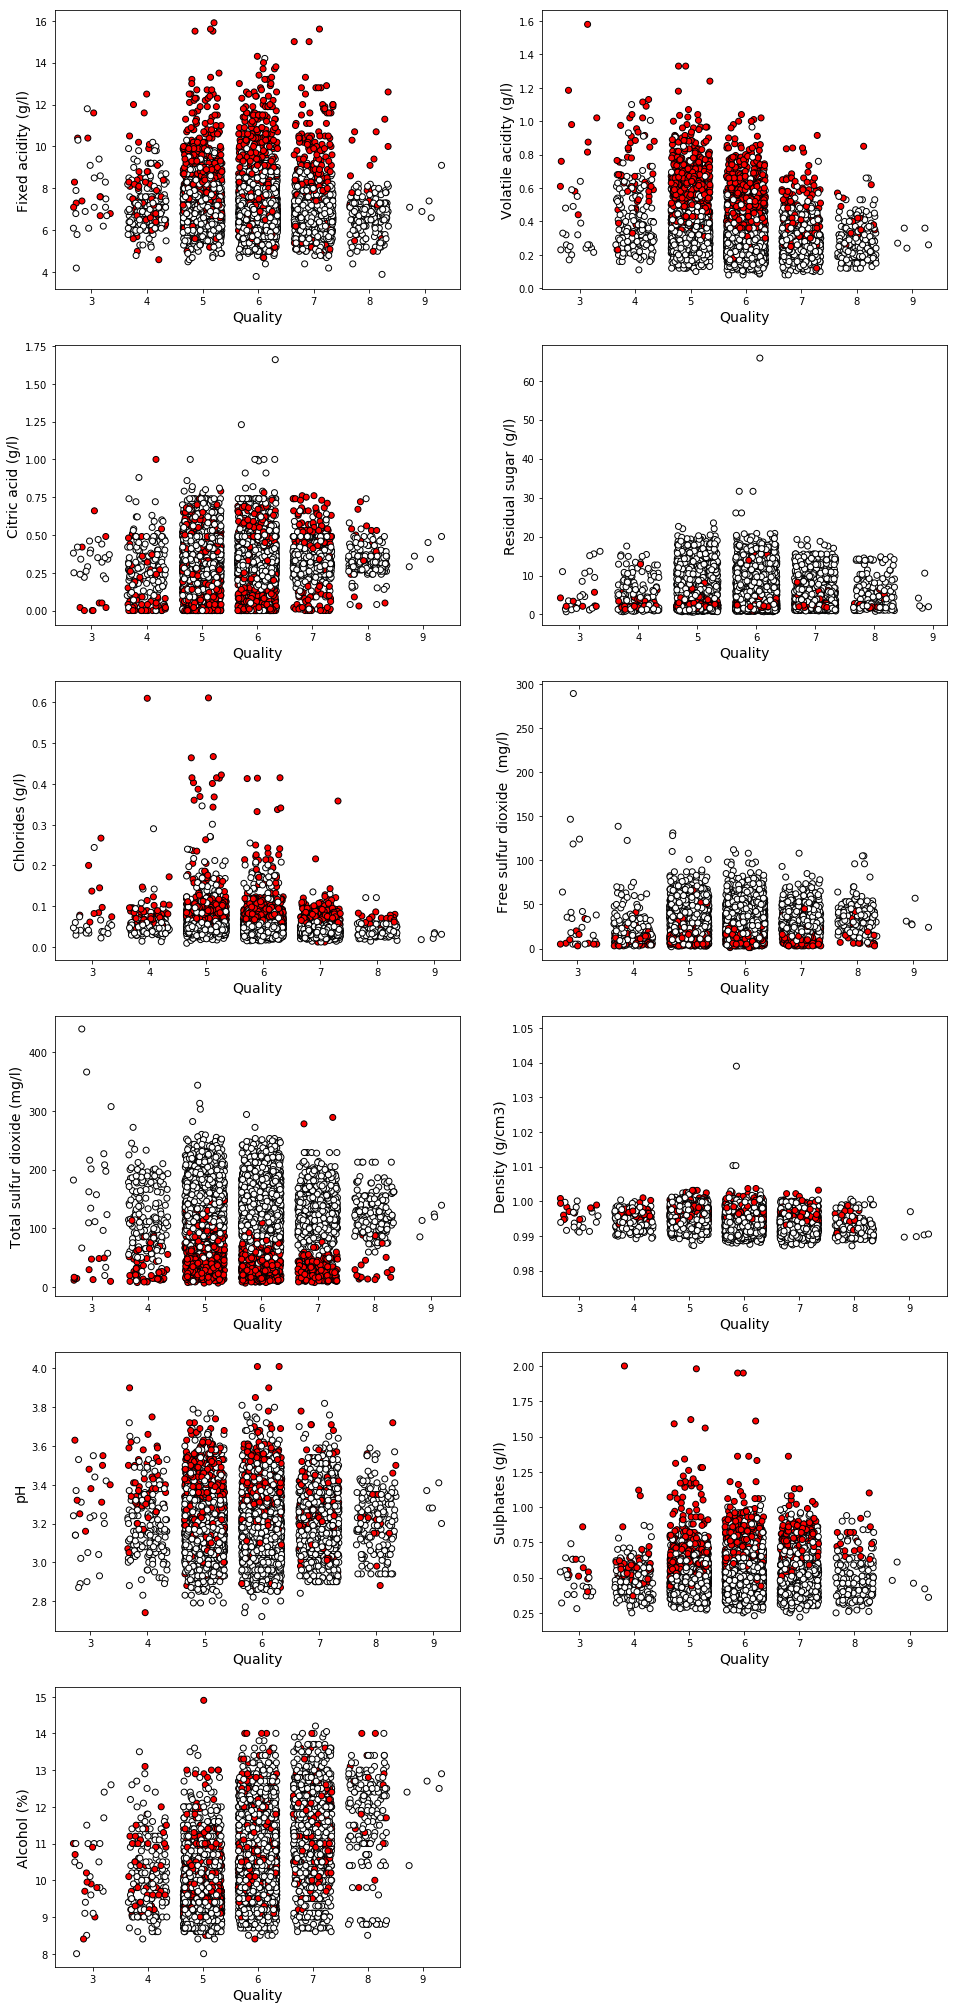

In [12]:
def jitter(arr):
    return arr + np.random.uniform(low=-0.35, high=0.35, size=len(arr))

pyplot.figure(figsize(16, 36))
for i in range (1, 12):
    pyplot.subplot(6, 2, i)
    pyplot.scatter(jitter(wine['quality']), wine.iloc[:, i], color=wine["Type"], edgecolors="black")
    pyplot.xlabel('Quality', fontsize=14)
    pyplot.ylabel(str(wine.columns[i]), fontsize=14)

Некоторые из признаков коррелируют с качеством вина.

## Линейная регрессия

Попробуем предсказать оценку исходя только из типа вина

In [13]:
regressor = LinearRegression()
regressor.fit(X_train['Type'].values.reshape(-1,1), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
y_train_predictions = regressor.predict(X_train['Type'].values.reshape(-1,1))

In [15]:
y_test_predictions = regressor.predict(X_test['Type'].values.reshape(-1,1))

Посмотри на ошибки предсказания:

In [16]:
sqrt(mean_squared_error(y_train_predictions, y_train))

0.86565849649415927

In [17]:
sqrt(mean_squared_error(y_test_predictions, y_test))

0.87103748986333718

Построим и обучим линейную модель на всех признаках

In [18]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Посмотрим на ошибки предсказания и увидим что они существенно уменьшились:

In [19]:
sqrt(mean_squared_error(lm.predict(X_train), y_train))

0.73763831836447602

In [20]:
sqrt(mean_squared_error(lm.predict(X_test), y_test))

0.71715945069988762

Построим график, истинных оценок и их пресказаний для обучающей и тестовой выборок

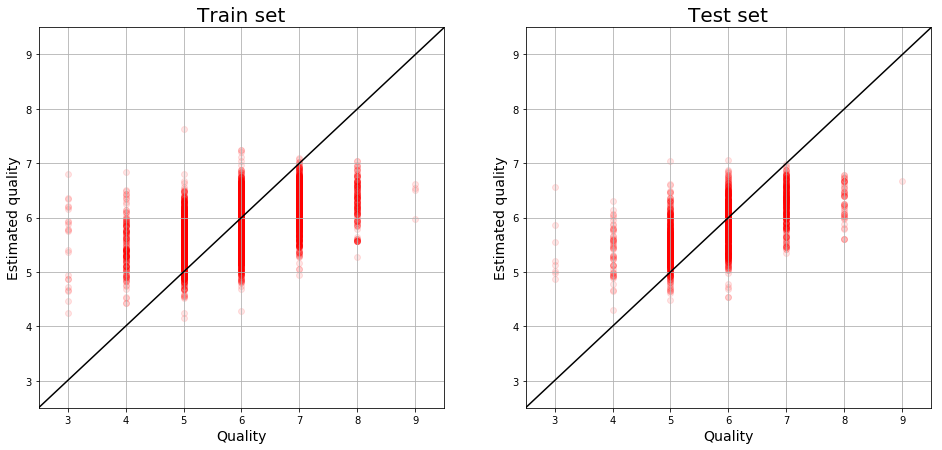

In [21]:
plt.figure(figsize(16,7))
plt.subplot(121)
pyplot.scatter(y_train, lm.predict(X_train), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Train set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

plt.subplot(122)
pyplot.scatter(y_test, lm.predict(X_test), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Test set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

## Случайный лес

Попробуем применить к выборке случайный лес:

In [22]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=2)

In [23]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Видим, что качество предсказание еще улучшилось:

In [24]:
sqrt(mean_squared_error(rf.predict(X_train), y_train))

0.29589382367101358

In [25]:
sqrt(mean_squared_error(rf.predict(X_test), y_test))

0.59362320577404704

Существенное различие в качестве предсказания на обучающей и тестовой выборках указывает на переобучение модели.

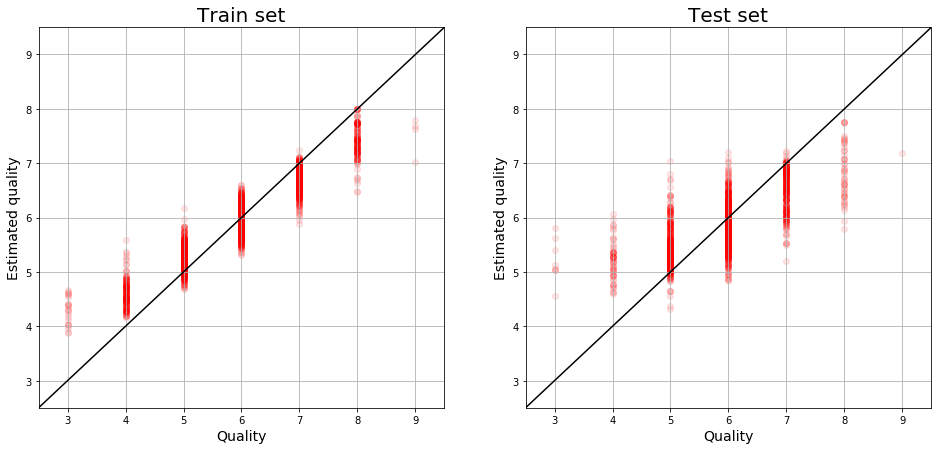

In [26]:
plt.figure(figsize(16,7))
plt.subplot(121)
pyplot.scatter(y_train, rf.predict(X_train), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Train set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

plt.subplot(122)
pyplot.scatter(y_test, rf.predict(X_test), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Test set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

Видно, что график вытянулся еще больше вдоль диагонали, что показывает улучшение качества предсказания.

Посмотрим, какие признаки обладают для данной модели наибольшей предсказательной способностью:

In [27]:
importances = pd.DataFrame(list(zip(X_train.columns, rf.feature_importances_)))
importances.columns = ['feature name', 'importance']
importances.sort_values(by='importance', ascending=False)

,feature name,importance
11,Alcohol (%),0.264370
2,Volatile acidity (g/l),0.127706
6,Free sulfur dioxide (mg/l),0.085529
10,Sulphates (g/l),0.079882
7,Total sulfur dioxide (mg/l),0.071759
9,pH,0.067891
4,Residual sugar (g/l),0.066835
5,Chlorides (g/l),0.064155
3,Citric acid (g/l),0.058790
8,Density (g/cm3),0.056645


И мы видим, что сильнее всего на экспертную оценку качества вина влияет содержание в нём алкоголя.